In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math

'''
y[n] = exp(-i 2*pi*n*k/N) + w[n]
w[n] = a[n] + ib[n]
SNR = (1/(s^2))
SNRdB = 10*log10(SNR). 
'''

'''
N = 32
m = 32
batchsize = 250
snd = 5db
neural = 1.0
bin = .984
'''
'''
N = 512
m = 32
batchsize = 250
snd = 5db
neural = 1.0
bin = .06
'''


Bad key "lines.dashed_pattern" on line 18 in
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.dashdot_pattern" on line 19 in
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.dotted_pattern" on line 20 in
c:\users\jains\appdata\local\programs\python\python36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
o

'\nN = 512\nm = 32\nbatchsize = 250\nsnd = 5db\nneural = 1.0\nbin = .06\n'

In [2]:
def pure_signal(N, k):
    return [np.exp(-1j * 2 * np.pi * k * n / N) for n in range(N)]

def noisy_signal(N, k, SNRdB):
    signal = pure_signal(N, k)
    s = np.sqrt(1 / (10 ** (SNRdB / 10)))
    a = np.random.randn(N) * s / np.sqrt(2)
    b = np.random.randn(N)* s / np.sqrt(2)
    noise = a + 1j*b
    return signal + noise

# returns tuple of m samples of noisy signals and chosen sampling indices
def subsampled_noisy(N, k, SNRdB, m):
    noisy_sig = noisy_signal(N, k, SNRdB)
    chosen_indices = np.sort(np.random.choice(range(N), size=m, replace=False))
    return (np.take(noisy_sig, chosen_indices), chosen_indices)

def imag_to_pair(signal):
    ret = []
    for i in signal:
        ret.append(np.round(np.real(i), 3))
        ret.append(np.round(np.imag(i), 3))
    return ret

def one_hot(N, batch_size, freqs):
    freqs_one_hot = np.zeros((batch_size, N))
    freqs_one_hot[np.arange(batch_size), freqs] = 1
    return freqs_one_hot

def batch_pure(N, batch_size):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = pure_signal(N, freq)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
    return signals, one_hot(N, batch_size, freqs)

def batch_noisy(N, SNRdB, batch_size):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
    return signals, one_hot(N, batch_size, freqs)
        
def batch_noisy_subsampled(N, SNRdB, m, batch_size):
    signals, freqs, indices = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal, index = subsampled_noisy(N, freq, SNRdB, m)
        signals.append(imag_to_pair(signal))
        freqs.append(freq)
        indices.append(index)
    return signals, one_hot(N, batch_size, freqs), indices

def batch_noisy_subsampled(N, SNRdB, m, batch_size, indices):
    signals, freqs, repeated_ind = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        sub_signal = np.take(signal, indices)
        signals.append(imag_to_pair(sub_signal))
        freqs.append(freq)
        repeated_ind.append(indices)
    return signals, one_hot(N, batch_size, freqs), repeated_ind

def batch_noisy_subsampled_raw(N, SNRdB, m, batch_size, indices):
    signals, freqs, repeated_ind = [], [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        signal = noisy_signal(N, freq, SNRdB)
        sub_signal = np.take(signal, indices)
        signals.append(imag_to_pair(sub_signal))
        freqs.append([freq])
        repeated_ind.append(indices)
    return signals, freqs, repeated_ind

def test_noisy_mle(N, signals, freqs):
    count = 0
    imag_signals = []    
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)
                     
    for index in range(len(signals)):
        cleans = [pure_signal(N, i) for i in range(N)]
        dots = [np.absolute(np.vdot(imag_signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            count += 1
    return count / len(freqs)

def test_noisy_subsampled_mle(N, signals, freqs, indices):
    count = 0
    imag_signals = []    
    for index in range(len(signals)):
        sig = signals[index]
        imag_sig = [(sig[i] + 1j*sig[i+1]) for i in np.arange(len(sig), step=2)]
        imag_signals.append(imag_sig)
                     
    for index in range(len(signals)):
        cleans = [np.take(pure_signal(N, i), indices[index]) for i in range(N)]
        dots = [np.absolute(np.vdot(imag_signals[index], cleans[i])) for i in range(N)]
        if np.argmax(freqs[index]) == np.argmax(dots):
            count += 1
    return count / len(freqs)

In [3]:
def make_signal(w,theta,n):
    """
    Assumes normalized amplitude
    """
    t = np.arange(n)
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,n):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
    return noise

def make_noisy_signal(w,theta,SNRdb,n):
    sigma2 = get_sigma2_from_snrdb(SNRdb)
    signal = make_signal(w,theta,n)
    noise  = make_noise(sigma2,n)
    return signal + noise

# N = divisor of w0
# m = num samples
def make_batch_noisy(batch_size, SNRdb, N, m, binary=False):
    signals, freqs = [], []
    for i in range(batch_size):
        freq = np.random.randint(0, N)
        w = (2 * np.pi * freq / N) % (2 * np.pi)
        sig = make_noisy_signal(w, 0, SNRdb, m)
        signals.append(sig)
        freqs.append(freq)
    if binary:
        return signals, make_binary(freqs, N), one_hot(N, batch_size, freqs)
    return signals, one_hot(N, batch_size, freqs)

def make_batch_singleton(batch_size, SNRdb, N, m):
    signals, freqs = [], []
    sigma2 = get_sigma2_from_snrdb(SNRdB)
    for i in range(batch_size):
        val = np.random.poisson(0.79)
        if val == 0:
            signals.append(make_noise(0, m))
            freqs.append([1, 0, 0])
        if val == 1:
            signals.append(make_noisy_signal(2 * np.pi * np.random.randint(0, N) / N, 0, SNRdB, m))
            freqs.append([0, 1, 0])
        if val >= 2:
            signal = make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            for i in range(val - 1):
                signal += make_signal(2 * np.pi * np.random.randint(0, N) / N, 0, m)
            signals.append(signal + make_noise(sigma2, m))
            freqs.append([0, 0, 1])
    return signals, freqs

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = (3.0/2)*N/(N**2 - 1)
    
    w = [1 - ((i - (N/2 - 1))/(N/2))**2 for i in range(N-1)]
    
    return scaling*np.array(w)

def kays_method(my_signal):
    N = len(my_signal)
    w = kay_weights(N)
    
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    need_to_shift = np.any(angle_diff < -np.pi/2)
    if need_to_shift:    
        neg_idx = angle_diff < 0
        angle_diff[neg_idx] += np.pi*2
    
    return w.dot(angle_diff)

def kays_singleton_accuracy(test_signals, test_freqs, N):
    diffs = [s - make_signal(kays_method(s), 0, N) for s in test_signals]
    thresh, single_acc, other_acc, best_thresh = 0.0, 0, 0, 0
    for i in range(150):
        vals = [(sum(np.absolute(s)) / N) < thresh for s in diffs]
        single = sum([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] == [0, 1, 0]])
        other = sum([not vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]]) / len([vals[d] for d in range(len(vals)) if test_freqs[d] != [0, 1, 0]])        
        if single*1.5 + other > single_acc*1.5 + other_acc and other > 0.3:
            single_acc = single
            other_acc = other
            best_thresh = thresh
        thresh += 0.05
    print('thresh: ', best_thresh)
    return single_acc, other_acc

def test_kays(signals, freqs, N):
    count = 0
    for sig, freq in zip(signals, freqs):
        res = kays_method(sig)
        res = round(res * N / (2 * np.pi))
        if np.argmax(freq) == res:
            count += 1
    return count / len(signals)

def test_mle(signals, freqs, N, m):
    count = 0
    for sig, freq in zip(signals, freqs):
        cleans = [make_signal(np.pi * 2 * w / N, 0, m) for w in range(N)]
        dots = [np.absolute(np.vdot(sig, clean)) for clean in cleans]
        if np.argmax(dots) == np.argmax(freq):
            count += 1
    return count / len(signals)
    
def make_binary(freqs, N):
    w = math.ceil(np.log2(N))
    return [[int(a) for a in list(np.binary_repr(f, width=w))] for f in freqs] 

def binary_to_int(binary_string):
    return tf.reduce_sum(
    tf.cast(tf.reverse(tensor=binary_string, axis=[0]), dtype=tf.int64)
    * 2 ** tf.range(tf.cast(tf.size(binary_string), dtype=tf.int64)))
    '''y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y'''

def hamming(pred, act):
    return np.count_nonzero(pred != act)
    

In [4]:
snrs = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
N = 512
m = 32
accs_kay, accs_mle = [], []
for snr in snrs:
    sig, freq = make_batch_noisy(1000, snr, N, m)
    print(test_kays(sig, freq, N))

0.74
0.68
0.586
0.522
0.481
0.387
0.3
0.234
0.15
0.105
0.055


In [31]:
'''snrs = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
N = 512
m = 32
accs_kay, accs_mle = [], []
for snr in snrs:
    sig, freq = make_batch_noisy(1000, snr, N, m)
    accs_kay.append(test_kays(sig, freq, N))
    accs_mle.append(test_mle(sig, freq, N, m))
accs2_kay, accs2_mle = [], []
snr = 10
ms = [128, 96, 64, 48, 32, 24, 16, 8]
for currm in ms:
    sig, freq = make_batch_noisy(1000, snr, N, currm)
    accs2_kay.append(test_kays(sig, freq, N))
    accs2_mle.append(test_mle(sig, freq, N, currm))'''

test_signals, test_freqs = make_batch_singleton(2000, 10, 256, 32)
diffs = [kays_singleton(s, 32) for s in test_signals]
acc = sum([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]]) / len([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]])
print(acc)
acc2 = sum([not diffs[d] for d in range(len(diffs)) if test_freqs[d] != [0, 1, 0]]) / len([diffs[d] for d in range(len(diffs)) if test_freqs[d] != [0, 1, 0]])
print(acc2)
'''plt.hist([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]]) 
plt.show()
print(np.mean([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]]))
print(np.median([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]]))
plt.hist([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [1, 0, 0]]) 
print(np.mean([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [1, 0, 0]]))
print(np.median([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [1, 0, 0]]))
plt.show()
plt.hist([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 0, 1]]) 
print(np.mean([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 0, 1]]))
print(np.median([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 0, 1]]))
plt.show()'''

0.7330246913580247
0.996301775147929


'plt.hist([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]]) \nplt.show()\nprint(np.mean([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]]))\nprint(np.median([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 1, 0]]))\nplt.hist([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [1, 0, 0]]) \nprint(np.mean([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [1, 0, 0]]))\nprint(np.median([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [1, 0, 0]]))\nplt.show()\nplt.hist([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 0, 1]]) \nprint(np.mean([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 0, 1]]))\nprint(np.median([diffs[d] for d in range(len(diffs)) if test_freqs[d] == [0, 0, 1]]))\nplt.show()'

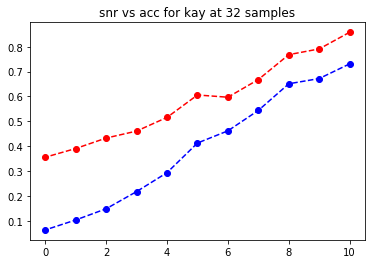

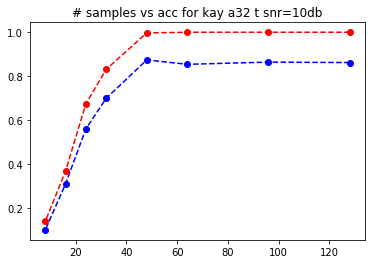

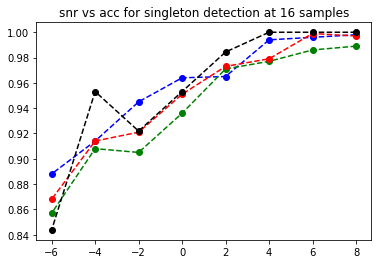

In [5]:
plt.plot(np.load('./data/snr/snrs.npy'), np.load('./data/snr/kay.npy'), '--bo')
plt.plot(np.load('./data/snr/snrs.npy'), np.load('./data/snr/mle.npy'), '--ro')
plt.title('snr vs acc for kay at 32 samples')
plt.show()
plt.plot(np.load('./data/m/ms.npy'), np.load('./data/m/kay.npy'), '--bo')
plt.plot(np.load('./data/m/ms.npy'), np.load('./data/m/mle.npy'), '--ro')
plt.title('# samples vs acc for kay a32 t snr=10db')
plt.show()
plt.plot(np.load('./data/single/snrs.npy'), np.load('./data/single/nn_accs.npy'), '--bo') # (5, 3, 3) (8, 16, 32)
plt.plot(np.load('./data/single/snrs.npy'), np.load('./data/single/nn_accs2.npy'), '--go') # (5, 3, 3) (2, 3, 4)
plt.plot(np.load('./data/single/snrs.npy'), np.load('./data/single/nn_accs3.npy'), '--ro') # (5, 3, 3) (4, 6, 8)
plt.plot(np.load('./data/single/snrs.npy'), np.load('./data/single/nn_accs4.npy'), '--ko') # (5, 3, 3) (2, 2, 2)
plt.title('snr vs acc for singleton detection at 16 samples')
plt.show()
# 1000 samples foreach trial

Training Finished for snr= 8
Testing Accuracy Neural: 0.999
thresh:  1.7500000000000009
Testing Accuracy Kay: 0.9971830985915493 0.9736434108527132
Training Finished for snr= 6
Testing Accuracy Neural: 0.999
thresh:  1.7500000000000009
Testing Accuracy Kay: 0.9717514124293786 0.9907120743034056
Training Finished for snr= 4
Testing Accuracy Neural: 0.999
thresh:  1.800000000000001
Testing Accuracy Kay: 0.9491525423728814 0.9814241486068112
Training Finished for snr= 2
Testing Accuracy Neural: 0.996
thresh:  1.850000000000001
Testing Accuracy Kay: 0.952 0.9744
Training Finished for snr= 0
Testing Accuracy Neural: 1.0
thresh:  1.900000000000001
Testing Accuracy Kay: 0.9306666666666666 0.9968
Training Finished for snr= -2
Testing Accuracy Neural: 0.796
thresh:  1.950000000000001
Testing Accuracy Kay: 0.7154929577464789 0.993798449612403
Training Finished for snr= -4
Testing Accuracy Neural: 0.972
thresh:  1.950000000000001
Testing Accuracy Kay: 0.02459016393442623 1.0
Training Finished for

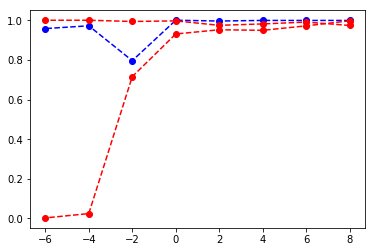

In [14]:
#cnn singleton detector

nn_accs = []
kay_1s = []
kay_2s = []
snrs = [8, 6, 4, 2, 0, -2, -4, -6]

for SNRdB in snrs:

    N = 27000 #512
    #SNRdB = 0
    m = 300 #16

    # Parameters
    learning_rate = 0.005
    num_iter = 8000
    batch_size = 1000

    # Network Parameters
    num_classes = 3

    # tf Graph input
    X = tf.placeholder("float", [None, m, 2])
    Y = tf.placeholder("float", [None, num_classes])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([5, 2, 2])), # filtersize, in channels, outchannels
        'out': tf.Variable(tf.random_normal([(m-4-2-2)*2, num_classes])),
        'h2': tf.Variable(tf.random_normal([3, 2, 2])),
        'h3': tf.Variable(tf.random_normal([3, 2, 2]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([2])),
        'out': tf.Variable(tf.random_normal([num_classes])),
        'b2': tf.Variable(tf.random_normal([2])),
        'b3': tf.Variable(tf.random_normal([2]))
    }

    test_signals, test_freqs = make_batch_singleton(batch_size, SNRdB, N, m)
    test_signals_pair = np.zeros((batch_size, m, 2))
    test_signals_pair[:, :, 0] = np.real(test_signals)
    test_signals_pair[:, :, 1] = np.imag(test_signals)
    training_size = 500
    dict = {}
    for i in range(training_size):
        batch_x, batch_y = make_batch_singleton(batch_size, SNRdB, N, m)
        batch_x_pair = np.zeros((batch_size, m, 2))
        batch_x_pair[:, :, 0] = np.real(batch_x)
        batch_x_pair[:, :, 1] = np.imag(batch_x)
        dict[i] = (batch_x_pair, batch_y)

    def neural_net(x):
        layer_1 = tf.add(tf.nn.conv1d(x, weights['h1'], 1, 'VALID'), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.nn.conv1d(hidden_1, weights['h2'], 1, 'VALID'), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        layer_3 = tf.add(tf.nn.conv1d(hidden_2, weights['h3'], 1, 'VALID'), biases['b3'])
        hidden_3 = tf.nn.relu(layer_3)
        hidden_3 = tf.reshape(hidden_3, [batch_size, -1])
        out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.nn.softmax(logits)
    losses, accuracies = [], []

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y))  
    '''+ 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out']) \
    + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out']) '''
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            batch_x_pair, batch_y = dict[step % training_size]

            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
            if step % 500 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                     Y: batch_y})

                #print("pred: ", [np.argmax(a) for a in pred[:8]])
                #print("act:", [np.argmax(a) for a in batch_y[:8]])
                accuracies.append(acc)
                losses.append(loss)
                #print("snr: ", SNRdB)
                #print("Iter " + str(step) + ", Minibatch Loss= " + \
                #      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                #      "{:.3f}".format(acc))
        print("Training Finished for snr=", SNRdB)

        nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})        
        print("Testing Accuracy Neural:", nn_acc)
        diffs = [kays_singleton(s, m) for s in test_signals]
        single, other = kays_singleton_accuracy(test_signals, test_freqs, m)
        print("Testing Accuracy Kay:", single, other)
        nn_accs.append(nn_acc)
        kay_1s.append(single)
        kay_2s.append(other)
#np.save('./data/single/snrs', snrs)
#np.save('./data/single/nn_accs4', nn_accs)
plt.plot(snrs, nn_accs, '--bo')
plt.plot(snrs, kay_1s, '--ro')
plt.plot(snrs, kay_2s, '--ro')
plt.show()

In [ ]:
#cnn one hot

nn_accs = []
kay_accs = []

snrs = [5] #[8, 6, 4, 2, 0, -2, -4, -6]



for SNRdB in snrs:

    N = 512
    SNRdB = 5
    m = 32

    # Parameters
    learning_rate = 0.005
    num_iter = 10000
    batch_size = 250

    # Network Parameters
    num_classes = N

    # tf Graph input
    X = tf.placeholder("float", [None, m, 2])
    Y = tf.placeholder("float", [None, num_classes])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([5, 2, 3])), # filtersize, in channels, outchannels
        'out': tf.Variable(tf.random_normal([(m-4-2-2)*4, num_classes])),
        'h2': tf.Variable(tf.random_normal([3, 3, 4])),
        'h3': tf.Variable(tf.random_normal([3, 4, 4]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([3])),
        'out': tf.Variable(tf.random_normal([num_classes])),
        'b2': tf.Variable(tf.random_normal([4])),
        'b3': tf.Variable(tf.random_normal([4]))
    }

    indices = np.sort(np.random.choice(range(N), size=m, replace=False))

    test_signals, test_freqs = make_batch_noisy(batch_size, SNRdB, N, m)
    test_signals_pair = np.zeros((batch_size, m, 2))
    test_signals_pair[:, :, 0] = np.real(test_signals)
    test_signals_pair[:, :, 1] = np.imag(test_signals)
    
    training_size = 500
    dict = {}
    for i in range(training_size):
        batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
        batch_x_pair = np.zeros((batch_size, m, 2))
        batch_x_pair[:, :, 0] = np.real(batch_x)
        batch_x_pair[:, :, 1] = np.imag(batch_x)
        dict[i] = (batch_x_pair, batch_y)

    def neural_net(x):
        layer_1 = tf.add(tf.nn.conv1d(x, weights['h1'], 1, 'VALID'), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.nn.conv1d(hidden_1, weights['h2'], 1, 'VALID'), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        layer_3 = tf.add(tf.nn.conv1d(hidden_2, weights['h3'], 1, 'VALID'), biases['b3'])
        hidden_3 = tf.nn.relu(layer_3)
        hidden_3 = tf.reshape(hidden_3, [batch_size, -1])
        out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.nn.softmax(logits)
    losses, accuracies = [], []

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y))  
    ''' + 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out'])\
    + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out'])'''
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            batch_x_pair, batch_y = dict[step % training_size]

            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
            if step % 500 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x_pair,
                                                                     Y: batch_y})

                print("pred: ", [np.argmax(a) for a in pred[:8]])
                print("act:", [np.argmax(a) for a in batch_y[:8]])
                accuracies.append(acc)
                losses.append(loss)
                print("snr: ", SNRdB)
                print("Iter " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Training Finished")

        #nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})
        #kay_acc = test_kays(test_signals, test_freqs, N)
        nn_acc = sess.run(accuracy, feed_dict={X: full_sig_pair, Y: full_onehot})
        kay_acc = test_kays(full_sig, full_onehot, N)
        
        print("Testing Accuracy Neural:", nn_acc)

        print("Testing Accuracy Kay:", kay_acc)
        nn_accs.append(nn_acc)
        kay_accs.append(kay_acc)
'''plt.plot(snrs, nn_accs, '--bo')
plt.plot(snrs, kay_accs, '--ro')
plt.show()
np.save('./data/freq/snrs', snrs)
np.save('./data/freq/nn_accs', nn_accs)
np.save('./data/freq/kay_accs', kay_accs)'''

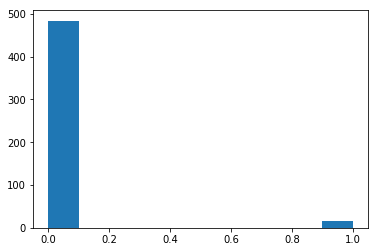

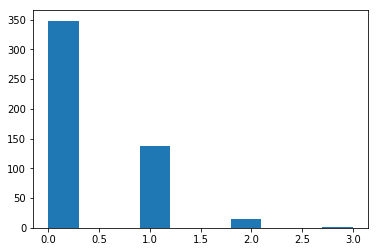

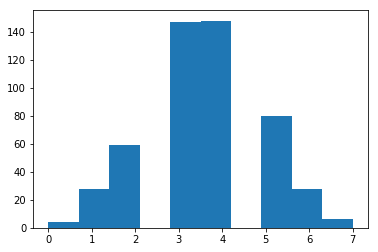

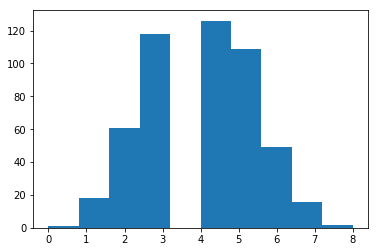

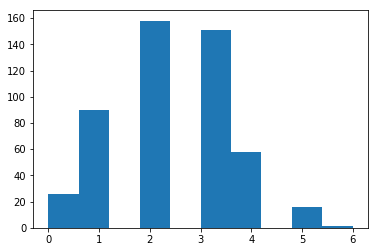

32 :  0.968
64 :  0.696
128 :  0.008
256 :  0.002
512 :  0.052


"plt.plot(snrs, nn_accs, '--bo')\nplt.plot(snrs, kay_accs, '--ro')\nplt.show()\nnp.save('./data/freq/snrs', snrs)\nnp.save('./data/freq/nn_accs', nn_accs)\nnp.save('./data/freq/kay_accs', kay_accs)"

In [41]:
#cnn binary

nn_accs = []
kay_accs = []

snrs = [0]
ns = [32, 64, 128, 256, 512]
hamming_list = []


for N in ns:

    #N = 128
    SNRdB = 5
    m = 32

    # Parameters
    learning_rate = 0.005
    num_iter = 8000
    batch_size = 500

    # Network Parameters
    num_classes = math.ceil(np.log2(N))

    # tf Graph input
    X = tf.placeholder("float", [None, m, 2])
    Y = tf.placeholder("float", [None, num_classes])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([5, 2, 3])), # filtersize, in channels, outchannels
        'out': tf.Variable(tf.random_normal([(m-4-2-2)*4, num_classes])),
        'h2': tf.Variable(tf.random_normal([3, 3, 4])),
        'h3': tf.Variable(tf.random_normal([3, 4, 4]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([3])),
        'out': tf.Variable(tf.random_normal([num_classes])),
        'b2': tf.Variable(tf.random_normal([4])),
        'b3': tf.Variable(tf.random_normal([4]))
    }

    test_signals, test_freqs, test_freqs_onehot = make_batch_noisy(batch_size, SNRdB, N, m, True)
    test_signals_pair = np.zeros((batch_size, m, 2))
    test_signals_pair[:, :, 0] = np.real(test_signals)
    test_signals_pair[:, :, 1] = np.imag(test_signals)
    
    training_size = 1000
    dict = {}
    for i in range(training_size):
        batch_x, batch_y, _ = make_batch_noisy(batch_size, SNRdB, N, m, True)
        batch_x_pair = np.zeros((batch_size, m, 2))
        batch_x_pair[:, :, 0] = np.real(batch_x)
        batch_x_pair[:, :, 1] = np.imag(batch_x)
        dict[i] = (batch_x_pair, batch_y)

    def neural_net(x):
        layer_1 = tf.add(tf.nn.conv1d(x, weights['h1'], 1, 'VALID'), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.nn.conv1d(hidden_1, weights['h2'], 1, 'VALID'), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        layer_3 = tf.add(tf.nn.conv1d(hidden_2, weights['h3'], 1, 'VALID'), biases['b3'])
        hidden_3 = tf.nn.relu(layer_3)
        hidden_3 = tf.reshape(hidden_3, [batch_size, -1])
        out_layer = tf.matmul(hidden_3, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.round(tf.nn.sigmoid(logits))
    losses, accuracies = [], []

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=logits, labels=Y))  
    ''' + 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out'])\
    + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out'])'''
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)


    correct_pred = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            batch_x_pair, batch_y = dict[step % training_size]

            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x_pair, Y: batch_y})
            if step % 100 == 0:
                # Calculate batch loss and accuracy
                loss, pred = sess.run([loss_op, prediction], feed_dict={X: batch_x_pair,
                                                                     Y: batch_y})
                #print("pred: ", [binary_to_int(a).eval() for a in pred[:8]])
                #print("act:", [binary_to_int(a).eval() for a in batch_y[:8]])
                #print("iter: ", step, " , loss: ", loss)
                #accuracies.append(acc)
                losses.append(loss)
                #acc = np.mean(np.equal(preds, acts))
                #print("snr: ", SNRdB)
                #print("Iter " + str(step) + ", Minibatch Loss= " + \
                #      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                #      "{:.3f}".format(acc))
            if step % 50000 == 0:
                pred = sess.run(prediction, feed_dict={X: batch_x_pair,
                                                                     Y: batch_y})
                preds = [binary_to_int(a).eval() for a in pred]
                acts = [binary_to_int(a).eval() for a in batch_y]
                print('batch accuracy: ', np.mean(np.equal(preds, acts)))
                pred = sess.run(prediction, feed_dict={X: test_signals_pair, Y: test_freqs})
                preds = [binary_to_int(a).eval() for a in pred]
                acts = [binary_to_int(a).eval() for a in test_freqs]
                print('test accuracy: ', np.mean(np.equal(preds, acts)))

        #print("Training Finished")

        loss, nn_acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: test_signals_pair, Y: test_freqs})
        #loss, nn_acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: full_sig_pair, Y: full_bin})
        hammings = [hamming(a, b) for a, b in zip(pred, test_freqs)]
        hamming_list.append(hammings)
        #print(np.mean(hammings))
        plt.hist(hammings)
        plt.show()
        preds = [binary_to_int(a).eval() for a in pred]
        acts = [binary_to_int(a).eval() for a in test_freqs] #test_freqs]
        nn_acc = np.mean(np.equal(preds, acts))

        #kay_acc = test_kays(test_signals, test_freqs, N)
        
        #print("Testing Accuracy Neural:", nn_acc)

        #print("Testing Accuracy Kay:", kay_acc)
        nn_accs.append(nn_acc)
        #kay_accs.append(kay_acc)
for a, n in zip(nn_accs, ns):
    print(n, ': ', a)
    #plt.hist(h)
    #plt.show()
'''plt.plot(snrs, nn_accs, '--bo')
plt.plot(snrs, kay_accs, '--ro')
plt.show()
np.save('./data/freq/snrs', snrs)
np.save('./data/freq/nn_accs', nn_accs)
np.save('./data/freq/kay_accs', kay_accs)'''

In [ ]:
#non linear one hot

nn_accs = []
mle_accs = []

snrs = [0]

for SNRdB in snrs:

    N = 512
    SNRdB = 10
    m = 32

    # Parameters
    learning_rate = 0.005
    num_iter = 30000
    batch_size = 64

    # Network Parameters
    n_hidden_1 = 64
    n_hidden_2 = 64 
    n_hidden_3 = 512
    num_input = m * 2 
    num_classes = N

    # tf Graph input
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, num_classes])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]))
        #'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'out': tf.Variable(tf.random_normal([num_classes])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2]))
        #'b3': tf.Variable(tf.random_normal([n_hidden_3])),
    }

    indices = np.sort(np.random.choice(range(N), size=m, replace=False))
    
    test_signals, test_freqs = make_batch_noisy(batch_size, SNRdB, N, m)
    test_signals_pair = [imag_to_pair(x) for x in test_signals]
    
    dict = {}
    training_samples = 500
    for i in range(training_samples):
        batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
        batch_x_pair = [imag_to_pair(x) for x in batch_x]
        dict[i] = (batch_x_pair, batch_y)

    def neural_net(x):
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        hidden_1 = tf.nn.dropout(hidden_1, 0.5)
        layer_2 = tf.add(tf.matmul(hidden_1, weights['h2']), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        hidden_2 = tf.nn.dropout(hidden_2, 0.5)
        #layer_3 = tf.add(tf.matmul(hidden_2, weights['h3']), biases['b3'])
        #hidden_3 = tf.nn.relu(layer_3)

        out_layer = tf.matmul(hidden_2, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.nn.softmax(logits)
    losses, accuracies = [], []

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
        logits=logits, labels=Y)) + 0.01*tf.nn.l2_loss(weights['h1']) + 0.01*tf.nn.l2_loss(weights['h2']) + 0.01*tf.nn.l2_loss(weights['out'])\
    + 0.01*tf.nn.l2_loss(biases['b1']) + 0.01*tf.nn.l2_loss(biases['b2']) + 0.01*tf.nn.l2_loss(biases['out'])
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            #batch_x, batch_y = make_batch_noisy(batch_size, SNRdB, N, m)
            #batch_x = [imag_to_pair(x) for x in batch_x]
            batch_x, batch_y = dict[i % training_samples]
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            if step % 999 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: batch_x,
                                                                     Y: batch_y})
                print("pred: ", [np.argmax(a) for a in pred[:8]])
                print("act:", [np.argmax(a) for a in batch_y[:8]])
                accuracies.append(acc)
                losses.append(loss)
                print("snr: ", SNRdB)
                print("Iter " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Training Finished")

        nn_acc = sess.run(accuracy, feed_dict={X: test_signals_pair, Y: test_freqs})
        kay_acc = test_kays(test_signals, test_freqs, N)
        
        print("Testing Accuracy Neural:", nn_acc)

        print("Testing Accuracy Kay:", kay_acc)
        nn_accs.append(nn_acc)
        mle_accs.append(kay_acc)
#np.save('./data/snrs', snrs)
#np.save('./data/nn_accs2', nn_accs)
#np.save('./data/mle_accs2', mle_accs)

In [ ]:
#nonlinear regression

nn_accs = []
mle_accs = []

snrs = [0]

for SNRdB in snrs:

    N = 512
    #SNRdB = 0
    m = 512

    # Parameters
    learning_rate = 0.05
    num_iter = 2500
    batch_size = 64

    # Network Parameters
    n_hidden_1 = 32#128
    n_hidden_2 = 32#64 
    n_hidden_3 = 32#128
    n_hidden_4 = 32#128
    n_hidden_5 = 32#128
    num_input = m * 2 #512 
    num_classes = N

    # tf Graph input
    X = tf.placeholder("float", [None, num_input])
    Y = tf.placeholder("float", [None, 1])

    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
        'out': tf.Variable(tf.random_normal([n_hidden_3, 1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
        'h4': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_4])),
        'h5': tf.Variable(tf.random_normal([n_hidden_4, n_hidden_5]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'out': tf.Variable(tf.random_normal([1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'b3': tf.Variable(tf.random_normal([n_hidden_3])),
        'b4': tf.Variable(tf.random_normal([n_hidden_4])),
        'b5': tf.Variable(tf.random_normal([n_hidden_5])),
    }

    indices = np.sort(np.random.choice(range(N), size=m, replace=False))

    test_signals, test_freqs, test_indices = batch_noisy_subsampled_raw(N, SNRdB, m, batch_size, indices)

    def neural_net(x):
        layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
        hidden_1 = tf.nn.relu(layer_1)
        hidden_1 = tf.nn.dropout(hidden_1, 0.5)
        layer_2 = tf.add(tf.matmul(hidden_1, weights['h2']), biases['b2'])
        hidden_2 = tf.nn.relu(layer_2)
        hidden_2 = tf.nn.dropout(hidden_2, 0.5)
        layer_3 = tf.add(tf.matmul(hidden_2, weights['h3']), biases['b3'])
        hidden_3 = tf.nn.relu(layer_3)
        hidden_3 = tf.nn.dropout(hidden_3, 0.5)
        layer_4 = tf.add(tf.matmul(hidden_3, weights['h4']), biases['b4'])
        hidden_4 = tf.nn.relu(layer_4)
        hidden_4 = tf.nn.dropout(hidden_4, 0.5)
        layer_5 = tf.add(tf.matmul(hidden_4, weights['h5']), biases['b5'])
        hidden_5 = tf.nn.relu(layer_5)
        hidden_5 = tf.nn.dropout(hidden_5, 0.5)

        out_layer = tf.matmul(hidden_5, weights['out']) + biases['out']
        return out_layer

    # Construct model
    logits = neural_net(X)
    prediction = tf.cast(logits, dtype=tf.int32)
    losses, accuracies = [], []

    # Define loss and optimizer
    #loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    #    logits=logits, labels=Y))
    
    loss_op = tf.reduce_mean((logits - Y) ** 2)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    # Evaluate model
    correct_pred = tf.equal(prediction, tf.cast(Y, dtype=tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for step in range(1, num_iter + 1):
            batch_x, batch_y, batch_ind = batch_noisy_subsampled_raw(N, SNRdB, m, batch_size, indices)
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
            if step % 100 == 0:
                # Calculate batch loss and accuracy
                loss, acc, pred = sess.run([loss_op, accuracy, prediction], feed_dict={X: test_signals,
                                                                     Y: test_freqs})
                #print("pred: ", [[i for i in a] for a in pred])
                #print("act:", batch_y)
                accuracies.append(acc)
                losses.append(loss)
                print("snr: ", SNRdB)
                print("Iter " + str(step) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss) + ", Training Accuracy= " + \
                      "{:.3f}".format(acc))

        print("Training Finished")

        nn_acc = sess.run(accuracy, feed_dict={X: test_signals, Y: test_freqs})
        mle_acc = test_noisy_subsampled_mle(N, test_signals, test_freqs, test_indices)
        
        print("Testing Accuracy Neural:", nn_acc)

        print("Testing Accuracy MLE:", mle_acc)
        nn_accs.append(nn_acc)
        mle_accs.append(mle_acc)
#np.save('./data/snrs', snrs)
#np.save('./data/nn_accs2', nn_accs)
#np.save('./data/mle_accs2', mle_accs)

In [ ]:
plt.plot(np.load('./data/snrs.npy'), np.load('./data/nn_accs2.npy'), '-bo')
plt.plot(np.load('./data/snrs.npy'), np.load('./data/mle_accs2.npy'), '-ro') 
plt.show()

# testing snr's for N=512, M=32

In [ ]:
plt.plot(np.load('./data/ms.npy'), np.load('./data/nn_accs.npy'), '-bo')
plt.plot(np.load('./data/ms.npy'), np.load('./data/mle_accs.npy'), '-ro') 
plt.show()

# testing subsampling m's for N=512, snr=0db

In [ ]:
plt.plot(accuracies)
plt.show()
plt.plot(losses)
plt.show()

'''
500 iter, N=256,3 hidden layer each w 256 neuron, batchsize=32
fully sampled: test accuracy ~98%
m=240: test accuracy ~28%'''
